In [1]:
import os
import numpy as np
import pandas as pd
import json
import pprint
import glob
import datetime
import random
import re
import warnings
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

warnings.filterwarnings('ignore')


2024-05-01 18:20:47.407016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Decided to exclude latitude and longitude bc they won't really tell us much in terms of conclusions since others had run into the issue of how latitude and longitude expained most of variation, which isn't that accurate in terms of an insight or business value conclusion form the experiment. 


# Importing Data:

In [3]:
# 1975 to 1981:

acc_vehc_sect_1 = pd.read_csv('acc_vehc_sect_1.csv')
acc_vehc_sect_1.head()

,YEAR,ST_CASE,PERSONS,HOUR,SCH_BUS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,1975,10001,4,20,0.0,0,1973.0,0.0,0.0
1,1975,10001,4,20,0.0,0,1969.0,0.0,0.0
2,1975,10001,4,20,0.0,0,1969.0,1.0,0.0
3,1975,10002,1,19,0.0,0,1971.0,1.0,0.0
4,1975,10003,2,22,0.0,0,1972.0,1.0,0.0


In [4]:
acc_vehc_sect_1.shape

(15770, 9)

In [5]:
acc_vehc_sect_1.dtypes

YEAR          int64
ST_CASE       int64
PERSONS       int64
HOUR          int64
SCH_BUS     float64
HIT_RUN       int64
MOD_YEAR    float64
DEATHS      float64
DR_DRINK    float64
dtype: object

#### Converting the number of deaths version into a categorical variable where all death values 3 and above are placed into a single category

In [6]:
# Converting the death values within DEATHS column plus handling floating-point strings
def categorize_deaths(x):
    # Initially, transform the value into a float, then an integer to process floating-point strings such as '0.0'.
    int_val = int(float(x))
    if int_val >= 3:
        return '3+'
    else:
        return str(int_val)


In [7]:
# Make sure the 'DEATHS' column is of string type
acc_vehc_sect_1['DEATHS'] = acc_vehc_sect_1['DEATHS'].astype(str)

# Apply the function that places each death value into a category
acc_vehc_sect_1['DEATHS'] = acc_vehc_sect_1['DEATHS'].apply(categorize_deaths)

# Convert the 'DEATHS' column to ordinal (categorical)
acc_vehc_sect_1['DEATHS'] = pd.Categorical(acc_vehc_sect_1['DEATHS'], 
                                           categories=['0', '1', '2', '3+'], 
                                           ordered=True)

acc_vehc_sect_1['DEATHS'].value_counts()


DEATHS
1     7584
0     7345
2      683
3+     158
Name: count, dtype: int64

In [8]:
X_1 = acc_vehc_sect_1.loc[:, ~(acc_vehc_sect_1.columns.isin(['DEATHS', 'ROAD_NAME', 'ST_CASE']))]

y_1 = acc_vehc_sect_1.loc[:,'DEATHS']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.25)

In [9]:
# 1982 to 1990:

acc_vehc_sect_2 = pd.read_csv('acc_vehc_sect_2.csv')

acc_vehc_sect_2.head()

,YEAR,ST_CASE,PERSONS,HOUR,ROAD_NAME,MILE_MARKER,SCH_BUS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,1982,10001,2,19,130,78.0,0,0,1972.0,2,0
1,1982,10002,2,23,285S,38944.0,0,0,1969.0,1,0
2,1982,10003,1,12,285N,38944.0,0,0,1970.0,1,1
3,1982,10004,1,1,15,36.0,0,0,1980.0,2,1
4,1982,10005,2,15,285W,38944.0,0,2,1966.0,0,1


In [10]:
# Make sure the 'DEATHS' column is of string type
acc_vehc_sect_2['DEATHS'] = acc_vehc_sect_2['DEATHS'].astype(str)

# Apply the function that places each death value into a category
acc_vehc_sect_2['DEATHS'] = acc_vehc_sect_2['DEATHS'].apply(categorize_deaths)

# Convert the 'DEATHS' column to ordinal (categorical)
acc_vehc_sect_2['DEATHS'] = pd.Categorical(acc_vehc_sect_2['DEATHS'], 
                                           categories=['0', '1', '2', '3+'], 
                                           ordered=True)

acc_vehc_sect_2['DEATHS'].value_counts()

DEATHS
1     9457
0     7251
2      847
3+     166
Name: count, dtype: int64

In [11]:
# Exclude the response variable & categorical variables with too many levels:

X_2 = acc_vehc_sect_2.loc[:, ~(acc_vehc_sect_2.columns.isin(['DEATHS', 'ROAD_NAME', 'ST_CASE']))]

y_2 = acc_vehc_sect_2.loc[:,'DEATHS']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.25)

In [12]:
# 1991 to 2000:

acc_vehc_sect_3 = pd.read_csv('acc_vehc_sect_3.csv')

acc_vehc_sect_3.head()

,YEAR,ST_CASE,NUM_PEDS,PERSONS,HOUR,ROAD_NAME,MILE_MARKER,SCH_BUS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,1991,10001,0,4,2,I75,3173.0,0,0,1989.0,1,0
1,1991,10002,0,1,8,307,87.0,0,0,1976.0,0,0
2,1991,10002,0,1,8,307,87.0,0,0,1985.0,0,0
3,1991,10002,0,1,8,307,87.0,0,0,1989.0,1,0
4,1991,10002,0,1,8,307,87.0,0,0,1987.0,1,0


In [13]:
# Make sure the 'DEATHS' column is of string type
acc_vehc_sect_3['DEATHS'] = acc_vehc_sect_3['DEATHS'].astype(str)

# Apply the function that places each death value into a category
acc_vehc_sect_3['DEATHS'] = acc_vehc_sect_3['DEATHS'].apply(categorize_deaths)

# Convert the 'DEATHS' column to ordinal (categorical)
acc_vehc_sect_3['DEATHS'] = pd.Categorical(acc_vehc_sect_3['DEATHS'], 
                                           categories=['0', '1', '2', '3+'], 
                                           ordered=True)

acc_vehc_sect_3['DEATHS'].value_counts()

DEATHS
1     8811
0     6094
2      787
3+     124
Name: count, dtype: int64

In [14]:
X_3 = acc_vehc_sect_3.loc[:, ~(acc_vehc_sect_3.columns.isin(['DEATHS', 'ROAD_NAME', 'ST_CASE']))]

y_3 = acc_vehc_sect_3.loc[:,'DEATHS']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.25)

In [15]:
# 2001 to 2007:

acc_vehc_sect_4 = pd.read_csv('acc_vehc_sect_4.csv')

acc_vehc_sect_4.head()

,YEAR,ST_CASE,NUM_PEDS,PERSONS,HOUR,ROAD_NAME,MILE_MARKER,SCH_BUS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,2001,10001,0,2,21,I-75 (SR 401),124.0,0,1,1997.0,1,0
1,2001,10002,0,4,10,I-75 (SR 401),12.0,0,1,1994.0,0,0
2,2001,10003,0,2,14,US-25 (SR 23),106.0,0,1,1992.0,0,0
3,2001,10004,0,2,1,237,30.0,0,1,1987.0,1,0
4,2001,10004,0,2,1,237,30.0,0,0,1989.0,0,0


In [16]:
# Make sure the 'DEATHS' column is of string type
acc_vehc_sect_4['DEATHS'] = acc_vehc_sect_4['DEATHS'].astype(str)

# Apply the function that places each death value into a category
acc_vehc_sect_4['DEATHS'] = acc_vehc_sect_4['DEATHS'].apply(categorize_deaths)

# Convert the 'DEATHS' column to ordinal (categorical)
acc_vehc_sect_4['DEATHS'] = pd.Categorical(acc_vehc_sect_4['DEATHS'], 
                                           categories=['0', '1', '2', '3+'], 
                                           ordered=True)

acc_vehc_sect_4['DEATHS'].value_counts()

DEATHS
1     6397
0     4165
2      467
3+      84
Name: count, dtype: int64

In [17]:
X_4 = acc_vehc_sect_4.loc[:, ~(acc_vehc_sect_4.columns.isin(['DEATHS', 'ROAD_NAME', 'ST_CASE']))]

y_4 = acc_vehc_sect_4.loc[:,'DEATHS']

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size = 0.25)

In [18]:
# 2008 to 2014:

acc_vehc_sect_5 = pd.read_csv('acc_vehc_sect_5.csv')

acc_vehc_sect_5.head()

,YEAR,ST_CASE,NUM_PEDS,NUM_VEHC,PERSONS,HOUR,ROAD_NAME,MILE_MARKER,LATITUDE,LONGITUD,SCH_BUS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,2008,10001,0,1,1,18,SR-253,158.0,30.963258,-84.568056,0,0,2006.0,0,0
1,2008,10002,0,2,5,17,SR-14 AL,105.0,33.604111,-84.538122,0,1,2003.0,0,0
2,2008,10002,0,2,5,17,SR-14 AL,105.0,33.604111,-84.538122,0,0,2000.0,0,0
3,2008,10003,0,2,3,13,SR-120,32.0,33.767589,-85.242619,0,1,2001.0,1,0
4,2008,10004,0,1,1,1,SR-104,68.0,33.557275,-82.160483,0,1,1993.0,0,0


In [19]:
# Make sure the 'DEATHS' column is of string type
acc_vehc_sect_5['DEATHS'] = acc_vehc_sect_5['DEATHS'].astype(str)

# Apply the function that places each death value into a category
acc_vehc_sect_5['DEATHS'] = acc_vehc_sect_5['DEATHS'].apply(categorize_deaths)

# Convert the 'DEATHS' column to ordinal (categorical)
acc_vehc_sect_5['DEATHS'] = pd.Categorical(acc_vehc_sect_5['DEATHS'], 
                                           categories=['0', '1', '2', '3+'], 
                                           ordered=True)

acc_vehc_sect_5['DEATHS'].value_counts()

DEATHS
1     5086
0     3358
2      326
3+      54
Name: count, dtype: int64

In [20]:
X_5 = acc_vehc_sect_5.loc[:, ~(acc_vehc_sect_5.columns.isin(['DEATHS','ROAD_NAME', 
                                                             'LATITUDE', 'LONGITUD', 'ST_CASE']))]

y_5 = acc_vehc_sect_5.loc[:,'DEATHS']

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size = 0.25)

In [21]:
# 2015 to 2022:

acc_vehc_sect_6 = pd.read_csv('acc_vehc_sect_6.csv')

acc_vehc_sect_6.head()

,YEAR,ST_CASE,STATENAME,NUM_PEDS,NUM_VEHC,PERSONS,MONTHNAME,DAYNAME,DAY_WEEKNAME,HOUR,...,WRK_ZONENAME,LGT_CONDNAME,WEATHERNAME,SCH_BUS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK,COUNTYNAME,CITYNAME
0,2015,10001,Georgia,1,1,2,November,9,Monday,19,...,NaN,Dark - Not Lighted,Rain,0,0,2003.0,1,1,NOT AVAILABLE,NOT AVAILABLE
1,2015,10002,Georgia,0,1,1,November,10,Tuesday,23,...,NaN,Dark - Not Lighted,Clear,0,0,2006.0,1,0,NOT AVAILABLE,NOT AVAILABLE
2,2015,10003,Georgia,1,2,5,November,10,Tuesday,21,...,NaN,Dark - Not Lighted,Cloudy,0,0,2008.0,1,1,NOT AVAILABLE,NOT AVAILABLE
3,2015,10004,Georgia,0,2,6,November,11,Wednesday,15,...,NaN,Daylight,Clear,0,0,2005.0,1,1,NOT AVAILABLE,NOT AVAILABLE
4,2015,10005,Georgia,1,1,1,November,11,Wednesday,19,...,NaN,Dark - Not Lighted,Clear,0,0,2006.0,1,0,NOT AVAILABLE,NOT AVAILABLE


In [22]:
# Make sure the 'DEATHS' column is of string type
acc_vehc_sect_6['DEATHS'] = acc_vehc_sect_6['DEATHS'].astype(str)

# Apply the function that places each death value into a category
acc_vehc_sect_6['DEATHS'] = acc_vehc_sect_6['DEATHS'].apply(categorize_deaths)

# Convert the 'DEATHS' column to ordinal (categorical)
acc_vehc_sect_6['DEATHS'] = pd.Categorical(acc_vehc_sect_6['DEATHS'], 
                                           categories=['0', '1', '2', '3+'], 
                                           ordered=True)

acc_vehc_sect_6['DEATHS'].value_counts()

DEATHS
1     6195
0     4751
2      371
3+      64
Name: count, dtype: int64

#### Generate dummy variables for Time Period 6:

Will make these variables with fewer levels into dummy variables:

MONTHNAME

DAY_WEEKNAME

ROUTENAME

RUR_URBNAME

FUNC_SYSNAME

COLLISION_TYPE

TYP_INTNAME

REL_ROADNAME

WRK_ZONENAME

LGT_CONDNAME

WEATHERNAME

Will exclude these variables because of too many levels:

STATENAME
ROAD_NAME

RD_OWNERNAME

HARM_EVNAME

COUNTYNAME

CITYNAME

In [23]:
columns_dummy = ['MONTHNAME', 'DAY_WEEKNAME', 'ROUTENAME', 'RUR_URBNAME', 
                    'FUNC_SYSNAME', 'COLLISION_TYPE', 'TYP_INTNAME', 'REL_ROADNAME', 
                    'WRK_ZONENAME', 'LGT_CONDNAME', 'WEATHERNAME']

dummy_df_6 = pd.get_dummies(acc_vehc_sect_6, columns=columns_dummy)

dummy_df_6 = dummy_df_6.drop(columns=['STATENAME', 'ROAD_NAME', 'RD_OWNERNAME', 
                                      'HARM_EVNAME', 'COUNTYNAME', 'CITYNAME',
                                      'LATITUDE','LONGITUD', 'ST_CASE'])  

dummy_df_6.head()


,YEAR,NUM_PEDS,NUM_VEHC,PERSONS,DAYNAME,HOUR,MILE_MARKER,SCH_BUS,HIT_RUN,MOD_YEAR,...,WEATHERNAME_Clear,WEATHERNAME_Cloudy,"WEATHERNAME_Fog, Smog, Smoke",WEATHERNAME_Not Reported,WEATHERNAME_Other,WEATHERNAME_Rain,WEATHERNAME_Reported as Unknown,WEATHERNAME_Severe Crosswinds,WEATHERNAME_Snow,WEATHERNAME_Unknown
0,2015,1,1,2,9,19,72.0,0,0,2003.0,...,False,False,False,False,False,True,False,False,False,False
1,2015,0,1,1,10,23,26.0,0,0,2006.0,...,True,False,False,False,False,False,False,False,False,False
2,2015,1,2,5,10,21,50.0,0,0,2008.0,...,False,True,False,False,False,False,False,False,False,False
3,2015,0,2,6,11,15,21.0,0,0,2005.0,...,True,False,False,False,False,False,False,False,False,False
4,2015,1,1,1,11,19,2.0,0,0,2006.0,...,True,False,False,False,False,False,False,False,False,False


In [24]:
dummy_df_6.shape

(11381, 117)

In [25]:
dummy_df_6.head()

,YEAR,NUM_PEDS,NUM_VEHC,PERSONS,DAYNAME,HOUR,MILE_MARKER,SCH_BUS,HIT_RUN,MOD_YEAR,...,WEATHERNAME_Clear,WEATHERNAME_Cloudy,"WEATHERNAME_Fog, Smog, Smoke",WEATHERNAME_Not Reported,WEATHERNAME_Other,WEATHERNAME_Rain,WEATHERNAME_Reported as Unknown,WEATHERNAME_Severe Crosswinds,WEATHERNAME_Snow,WEATHERNAME_Unknown
0,2015,1,1,2,9,19,72.0,0,0,2003.0,...,False,False,False,False,False,True,False,False,False,False
1,2015,0,1,1,10,23,26.0,0,0,2006.0,...,True,False,False,False,False,False,False,False,False,False
2,2015,1,2,5,10,21,50.0,0,0,2008.0,...,False,True,False,False,False,False,False,False,False,False
3,2015,0,2,6,11,15,21.0,0,0,2005.0,...,True,False,False,False,False,False,False,False,False,False
4,2015,1,1,1,11,19,2.0,0,0,2006.0,...,True,False,False,False,False,False,False,False,False,False


In [26]:
# Finding quantitative and categorical columns to help with dummy variable creation:
int_columns = dummy_df_6.select_dtypes(include=['int64']).columns.tolist()
float_columns = dummy_df_6.select_dtypes(include=['float64']).columns.tolist()
bool_columns = dummy_df_6.select_dtypes(include=['bool']).columns.tolist()


In [27]:
print("Integer Columns:", int_columns)


Integer Columns: ['YEAR', 'NUM_PEDS', 'NUM_VEHC', 'PERSONS', 'DAYNAME', 'HOUR', 'SCH_BUS', 'HIT_RUN', 'DR_DRINK']


In [28]:
print("Float/Double Columns:", float_columns)


Float/Double Columns: ['MILE_MARKER', 'MOD_YEAR']


In [29]:
all_columns = dummy_df_6.columns.tolist()

# Cateogrical columns
columns_to_exclude = dummy_df_6.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

columns_not_int_float_bool = [col for col in all_columns if col not in columns_to_exclude]

print("Columns that aren't int, float, or bool:", columns_not_int_float_bool)


Columns that aren't int, float, or bool: ['DEATHS']


In [30]:
len(columns_not_int_float_bool)

1

In [31]:
object_columns = dummy_df_6.select_dtypes(include=['object']).columns
dummy_df_6[object_columns].dtypes


Series([], dtype: object)

In [32]:
X_6 = dummy_df_6.loc[:, ~(dummy_df_6.columns.isin(['DEATHS']))]
y_6 = dummy_df_6.loc[:,'DEATHS']

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_6, y_6, test_size = 0.25)

In [33]:
type(X_train_1)

pandas.core.frame.DataFrame

In [34]:
type(y_train_1)

pandas.core.series.Series

# SMOTE for Re-Balancing the Dependent Variable's Imbalanced Class Distribution:

In [35]:
pd.unique(y_train_1)

['1', '0', '2', '3+']
Categories (4, object): ['0' < '1' < '2' < '3+']

In [36]:
class_dist_train_1 = Counter(y_train_1)
class_dist_train_1

Counter({'1': 5664, '0': 5520, '2': 518, '3+': 125})

In [37]:
class_dist_train_2 = Counter(y_train_2)
class_dist_train_2

Counter({'1': 7107, '0': 5407, '2': 645, '3+': 131})

In [38]:
class_dist_train_3 = Counter(y_train_3)
class_dist_train_3

Counter({'0': 4509, '1': 6659, '2': 605, '3+': 89})

In [39]:
class_dist_train_4 = Counter(y_train_4)
class_dist_train_4

Counter({'1': 4835, '2': 348, '0': 3095, '3+': 56})

In [40]:
class_dist_train_5 = Counter(y_train_5)
class_dist_train_5

Counter({'1': 3818, '0': 2521, '2': 238, '3+': 41})

In [41]:
class_dist_train_6 = Counter(y_train_6)
class_dist_train_6

Counter({'1': 4605, '0': 3592, '2': 290, '3+': 48})

In [42]:
class_distributions = [class_dist_train_1, class_dist_train_2, class_dist_train_3,
                       class_dist_train_4, class_dist_train_5, class_dist_train_6]

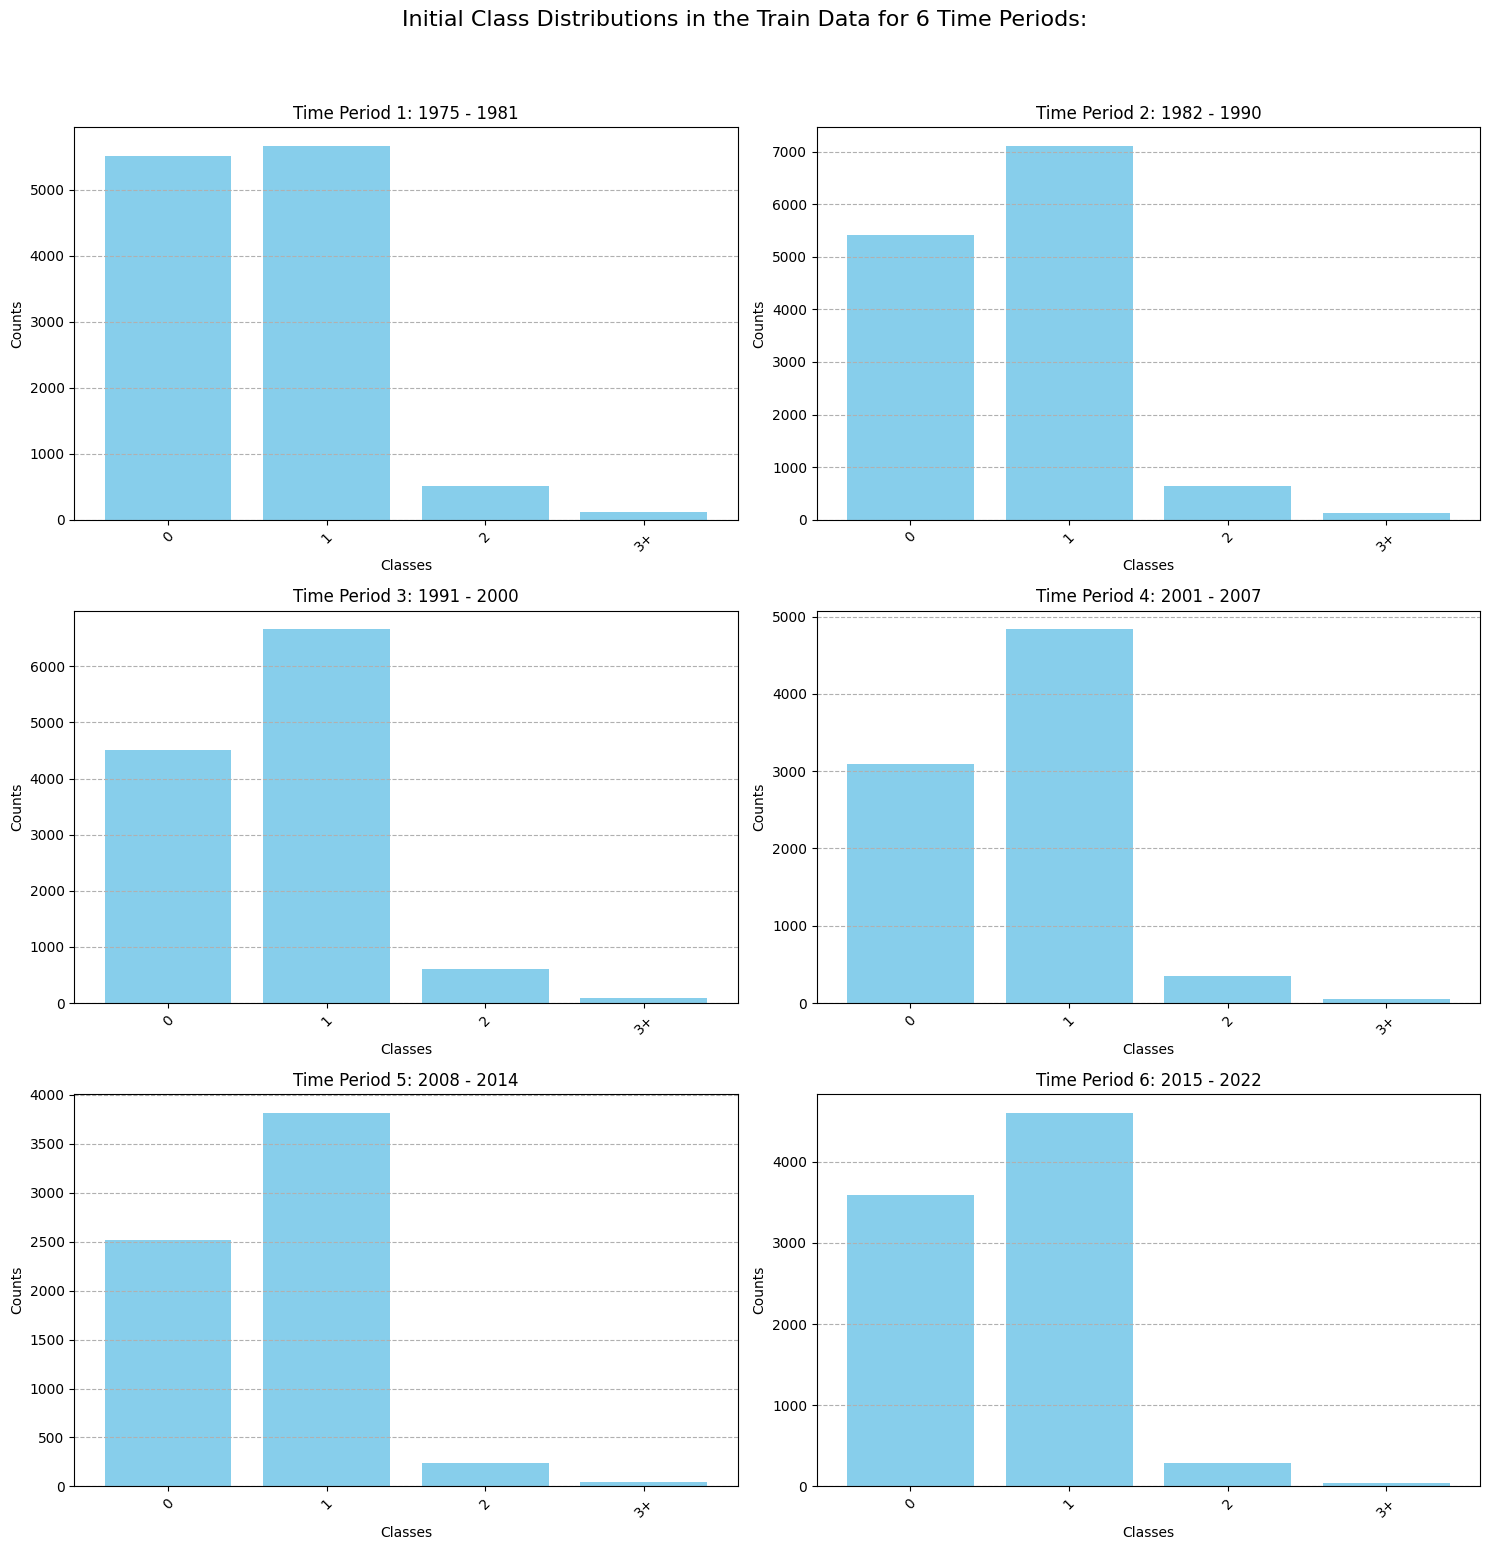

In [43]:
# Specify the classes' correct order
ordered_classes = ['0', '1', '2', '3+']

# Generate a 3x2 grid of dependent variable
# class distribution for each time period's data from 1 to 6:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  

axs = axs.flatten()

# Fill in each subplot with its class distribution:
for i, ax in enumerate(axs):
    values = [class_distributions[i][class_label] for class_label in ordered_classes]
    ax.bar(ordered_classes, values, color='skyblue')
    
    # Dictionary maps i to its corresponding range of years
    year_ranges = {
        0: "1975 - 1981",
        1: "1982 - 1990",
        2: "1991 - 2000",
        3: "2001 - 2007",
        4: "2008 - 2014",
        5: "2015 - 2022"
    }

    year_range = year_ranges[i]
 
    ax.set_xlabel('Classes') 
    ax.set_ylabel('Counts') 
    ax.set_title(f'Time Period {i+1}: {year_range}')  
    ax.set_xticks(ordered_classes)  # Specify x-ticks as the class labels
    ax.set_xticklabels(ordered_classes, rotation=45)  # Rotate labels so overlap doesn't happen
    ax.grid(axis='y', linestyle='--')  # Include horizontal grid lines

    
fig.suptitle('Initial Class Distributions in the Train Data for 6 Time Periods:', fontsize=16, y=1.03)

plt.tight_layout()  
plt.show()


In [44]:
# SMOTE object instantiation
smote = SMOTE(random_state=1)

In [45]:
# Generate synthetic train (not test) samples from SMOTE 

X_resampled_1, y_resampled_1 = smote.fit_resample(X_train_1, y_train_1)
print("Resampled Distribution for Time Period 1 Data: \n", Counter(y_resampled_1))

Resampled Distribution for Time Period 1 Data: 
 Counter({'1': 5664, '0': 5664, '2': 5664, '3+': 5664})


In [46]:
X_resampled_2, y_resampled_2 = smote.fit_resample(X_train_2, y_train_2)
print("Resampled Distribution for Time Period 2 Data: \n", Counter(y_resampled_2))

Resampled Distribution for Time Period 2 Data: 
 Counter({'1': 7107, '0': 7107, '2': 7107, '3+': 7107})


In [47]:
X_resampled_3, y_resampled_3 = smote.fit_resample(X_train_3, y_train_3)
print("Resampled Distribution for Time Period 3 Data: \n", Counter(y_resampled_3))

Resampled Distribution for Time Period 3 Data: 
 Counter({'0': 6659, '1': 6659, '2': 6659, '3+': 6659})


In [48]:
X_resampled_4, y_resampled_4 = smote.fit_resample(X_train_4, y_train_4)
print("Resampled Distribution for Time Period 4 Data: \n", Counter(y_resampled_4))

Resampled Distribution for Time Period 4 Data: 
 Counter({'1': 4835, '2': 4835, '0': 4835, '3+': 4835})


In [49]:
X_resampled_5, y_resampled_5 = smote.fit_resample(X_train_5, y_train_5)
print("Resampled Distribution for Time Period 5 Data: \n", Counter(y_resampled_5))

Resampled Distribution for Time Period 5 Data: 
 Counter({'1': 3818, '0': 3818, '2': 3818, '3+': 3818})


In [50]:
X_resampled_6, y_resampled_6 = smote.fit_resample(X_train_6, y_train_6)
print("Resampled Distribution for Time Period 6 Data: \n", Counter(y_resampled_6))

Resampled Distribution for Time Period 6 Data: 
 Counter({'1': 4605, '0': 4605, '2': 4605, '3+': 4605})


In [51]:
resamp_class_dist_train_1 = Counter(y_resampled_1)
resamp_class_dist_train_1

Counter({'1': 5664, '0': 5664, '2': 5664, '3+': 5664})

In [52]:
resamp_class_dist_train_2 = Counter(y_resampled_2)
resamp_class_dist_train_2

Counter({'1': 7107, '0': 7107, '2': 7107, '3+': 7107})

In [53]:
resamp_class_dist_train_3 = Counter(y_resampled_3)
resamp_class_dist_train_3

Counter({'0': 6659, '1': 6659, '2': 6659, '3+': 6659})

In [54]:
resamp_class_dist_train_4 = Counter(y_resampled_4)
resamp_class_dist_train_4

Counter({'1': 4835, '2': 4835, '0': 4835, '3+': 4835})

In [55]:
resamp_class_dist_train_5 = Counter(y_resampled_5)
resamp_class_dist_train_5

Counter({'1': 3818, '0': 3818, '2': 3818, '3+': 3818})

In [56]:
resamp_class_dist_train_6 = Counter(y_resampled_6)
resamp_class_dist_train_6

Counter({'1': 4605, '0': 4605, '2': 4605, '3+': 4605})

In [57]:
resamp_class_distributions = [resamp_class_dist_train_1, resamp_class_dist_train_2, 
                              resamp_class_dist_train_3, resamp_class_dist_train_4, 
                              resamp_class_dist_train_5, resamp_class_dist_train_6]

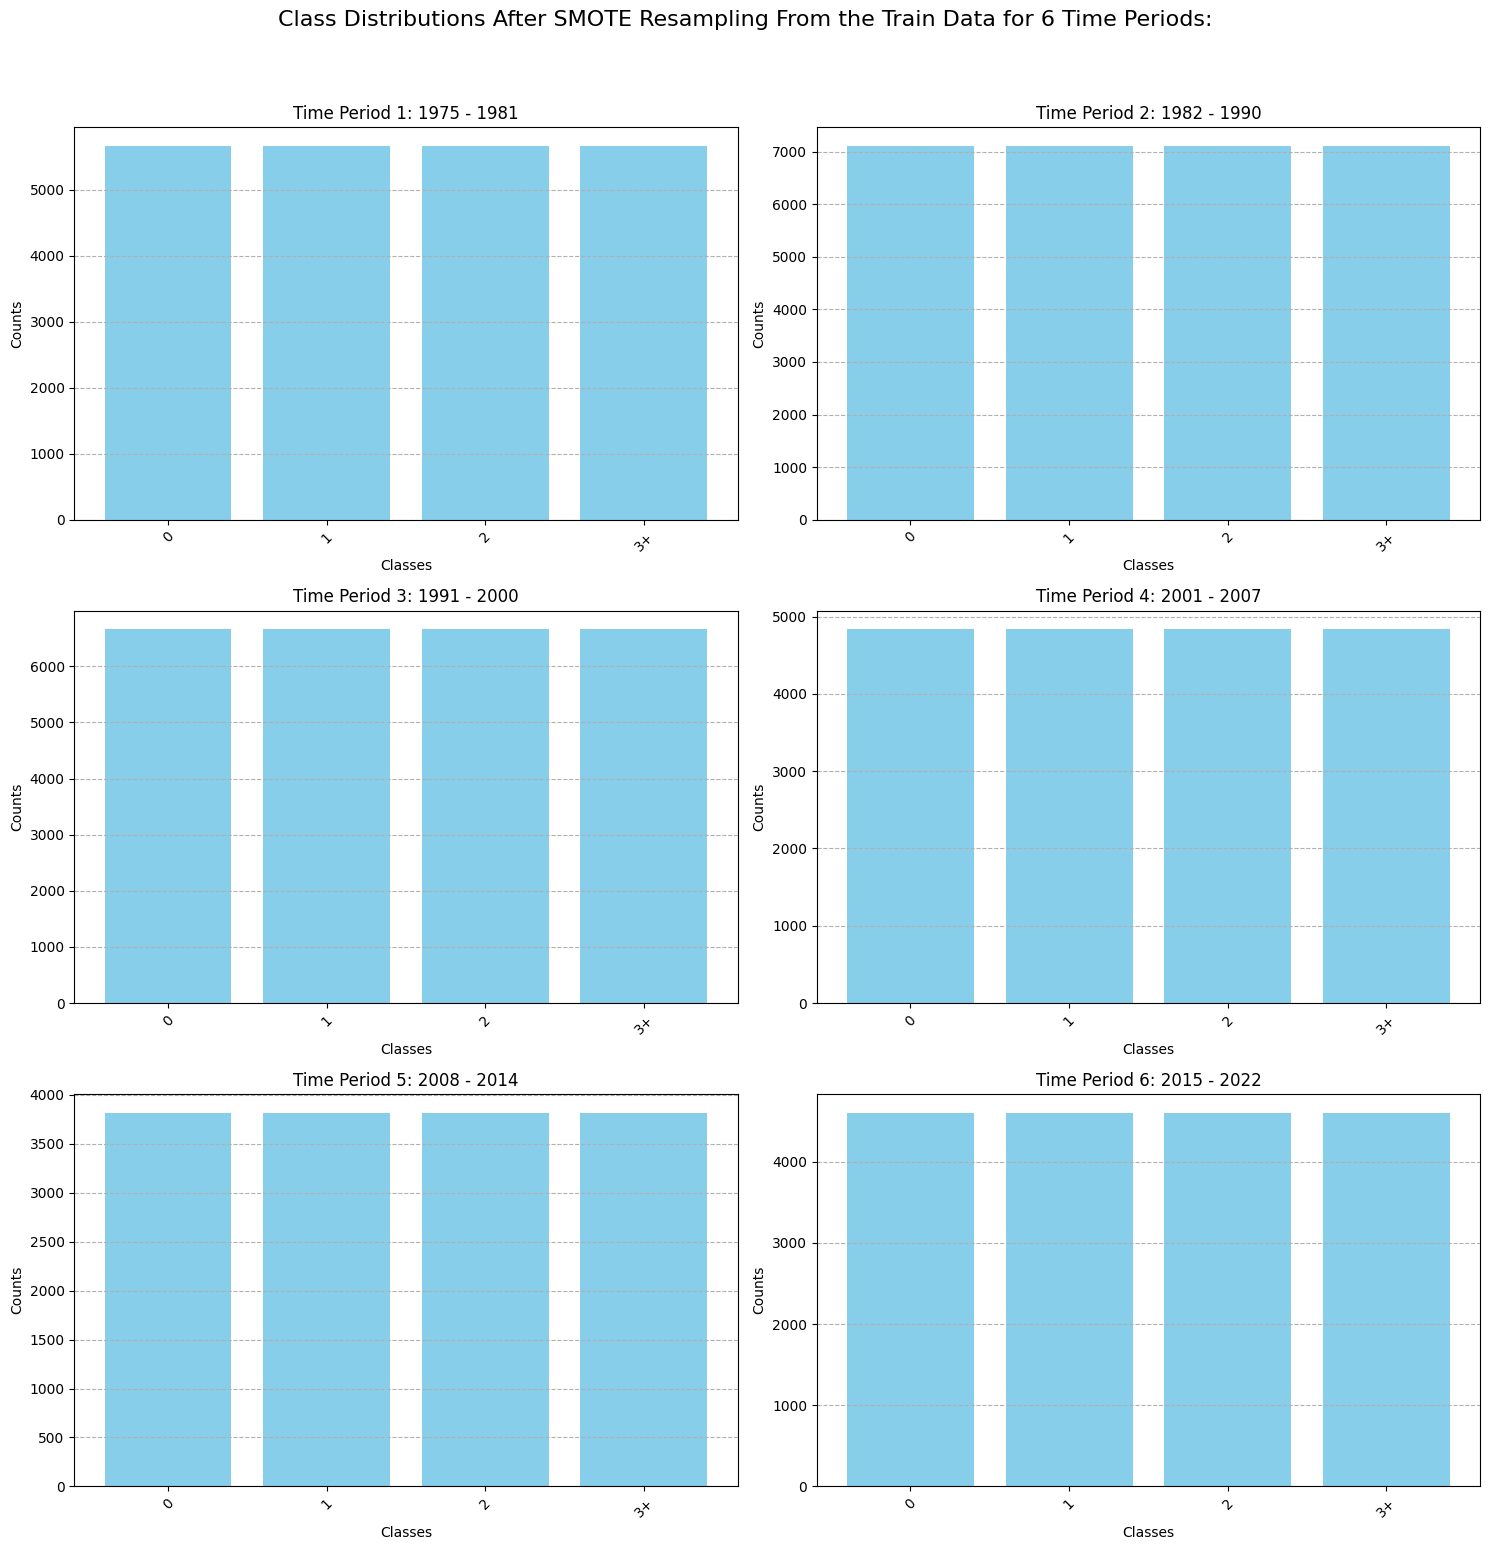

In [58]:
ordered_classes = ['0', '1', '2', '3+']

fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Adjust figure size as needed

axs = axs.flatten()

for i, ax in enumerate(axs):
    values = [resamp_class_distributions[i][class_label] for class_label in ordered_classes]
    ax.bar(ordered_classes, values, color='skyblue')
    
    
    # Dictionary maps i to its corresponding range of years
    year_ranges = {
        0: "1975 - 1981",
        1: "1982 - 1990",
        2: "1991 - 2000",
        3: "2001 - 2007",
        4: "2008 - 2014",
        5: "2015 - 2022"
    }

    year_range = year_ranges[i]
 
    ax.set_xlabel('Classes') 
    ax.set_ylabel('Counts') 
    ax.set_title(f'Time Period {i+1}: {year_range}') 
    ax.set_xticks(ordered_classes)  
    ax.set_xticklabels(ordered_classes, rotation=45)  
    ax.grid(axis='y', linestyle='--')  

# Add a supertitle
fig.suptitle('Class Distributions After SMOTE Resampling From the Train Data for 6 Time Periods:', fontsize=16, y=1.03)

plt.tight_layout()  
plt.show()  


# Creating Models with SMOTE Modified Variables:

For each model type:
1. Create 1 model that shows the deaths over the 47 years that has all the common columns from all 6 time periods
2. Create separate models for each time period: 1 with all regressors & 1 reduced model

#### TO DO: Filter out the common variables in all 6 time periods & put them into a common dataframe so that you can create models for all 47 years combined

### Random Forest Models:

#### Model 1 - Accidents from 1975 to 1981:

In [59]:
type(X_resampled_1)

pandas.core.frame.DataFrame

In [60]:
type(y_resampled_1)

pandas.core.series.Series

In [61]:
# Make sure all variables are quantitative:
X_resampled_1.dtypes

YEAR          int64
PERSONS       int64
HOUR          int64
SCH_BUS     float64
HIT_RUN       int64
MOD_YEAR    float64
DR_DRINK    float64
dtype: object

In [63]:
rf_mod_1 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_mod_1.fit(X_resampled_1, y_resampled_1)

# Test Predictions
preds_mod_1 = rf_mod_1.predict(X_test_1)

# Accuracy
acc_mod_1 = accuracy_score(y_test_1, preds_mod_1)
print("Test Accuracy:", acc_mod_1)


Test Accuracy: 0.48744610702510777


In [64]:
# Feature Importance Plot:
impts = rf_mod_1.feature_importances_

feature_names = X_resampled_1.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


MOD_YEAR: 0.4289052992339692
HOUR: 0.29124407414502657
YEAR: 0.11868269664219804
PERSONS: 0.08725899699532644
DR_DRINK: 0.06425193365705667
HIT_RUN: 0.005129134569180379
SCH_BUS: 0.004527864757242687


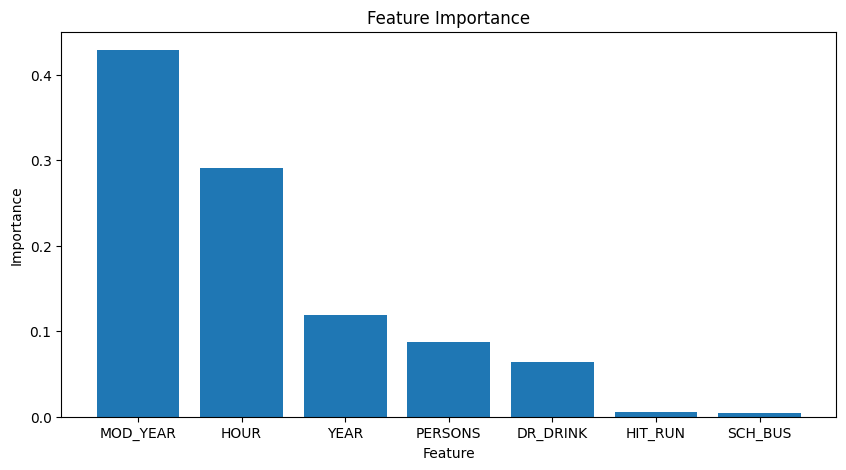

In [65]:
impts = rf_mod_1.feature_importances_

idxs = np.argsort(impts)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(len(impts)), impts[idxs], align="center")
plt.xticks(range(len(impts)), [feature_names[i] for i in idxs]) 
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


In [66]:
# Confusion Matrix:

# Create confusion matrix
conf_mat_1 = confusion_matrix(y_test_1, preds_mod_1)

# Empty sens and spec lists
sens_list = []
spec_list = []

# Find sensitivity and specificity for each class, where "positive" means equal to 
# the class and "negative" means not equal to the class
for i in range(conf_mat_1.shape[0]):
    TP = conf_mat_1[i, i]
    FN = np.sum(conf_mat_1[i, :]) - TP
    FP = np.sum(conf_mat_1[:, i]) - TP
    TN = np.sum(conf_mat_1) - (TP + FN + FP)
    
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    
    sens_list.append(sens)
    spec_list.append(spec)

# Print out classes' sens and spec values
for i, (sens, spec) in enumerate(zip(sens_list, spec_list)):
    print(f"Class {i}: Sensitivity = {sens}, Specificity = {spec}")


Class 0: Sensitivity = 0.49095890410958903, Specificity = 0.653918791312559
Class 1: Sensitivity = 0.5276041666666667, Specificity = 0.5887296094908552
Class 2: Sensitivity = 0.07272727272727272, Specificity = 0.9118581259925886
Class 3: Sensitivity = 0.030303030303030304, Specificity = 0.9685421994884911


#### Model 2 - Accidents from 1982 to 1990:

In [67]:
type(X_resampled_2)

pandas.core.frame.DataFrame

In [68]:
type(y_resampled_2)

pandas.core.series.Series

In [69]:
# Make sure all variables are quantitative:
X_resampled_2.dtypes

YEAR             int64
PERSONS          int64
HOUR             int64
MILE_MARKER    float64
SCH_BUS          int64
HIT_RUN          int64
MOD_YEAR       float64
DR_DRINK         int64
dtype: object

In [71]:
rf_mod_2 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_mod_2.fit(X_resampled_2, y_resampled_2)

# Test Predictions
preds_mod_2 = rf_mod_2.predict(X_test_2)

# Accuracy
acc_mod_2 = accuracy_score(y_test_2, preds_mod_2)
print("Test Accuracy:", acc_mod_2)


Test Accuracy: 0.47506206273978785


In [72]:
# Feature Importance Plot:
impts = rf_mod_2.feature_importances_

feature_names = X_resampled_2.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


MOD_YEAR: 0.35914867057630795
HOUR: 0.2208535502292056
MILE_MARKER: 0.20176218996458684
YEAR: 0.08710112639610798
PERSONS: 0.08511385594139026
DR_DRINK: 0.03259788898718015
HIT_RUN: 0.012752200377656644
SCH_BUS: 0.0006705175275645898


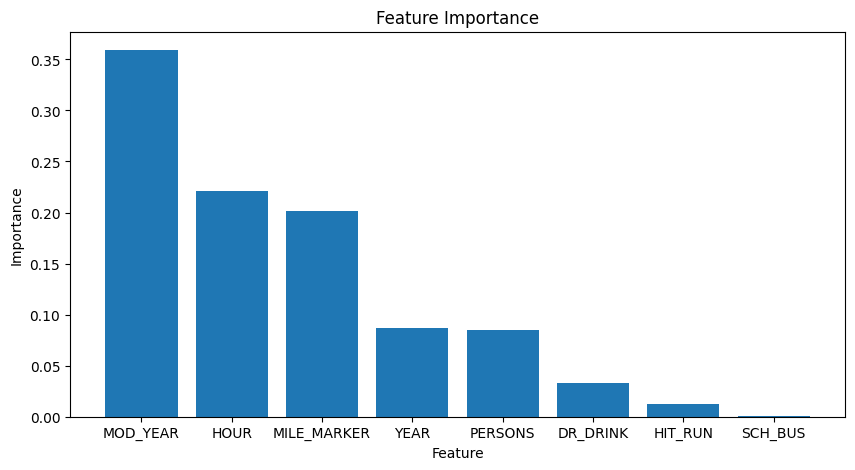

In [73]:
impts = rf_mod_2.feature_importances_

idxs = np.argsort(impts)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(len(impts)), impts[idxs], align="center")
plt.xticks(range(len(impts)), [feature_names[i] for i in idxs]) 
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


#### Model 3 - Accidents from 1991 to 2000:

In [74]:
type(X_resampled_3)

pandas.core.frame.DataFrame

In [75]:
type(y_resampled_3)

pandas.core.series.Series

In [76]:
# Make sure all variables are quantitative:
X_resampled_3.dtypes

YEAR             int64
NUM_PEDS         int64
PERSONS          int64
HOUR             int64
MILE_MARKER    float64
SCH_BUS          int64
HIT_RUN          int64
MOD_YEAR       float64
DR_DRINK         int64
dtype: object

In [78]:
rf_mod_3 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_mod_3.fit(X_resampled_3, y_resampled_3)

# Test Predictions
preds_mod_3 = rf_mod_3.predict(X_test_3)

# Accuracy
acc_mod_3 = accuracy_score(y_test_3, preds_mod_3)
print("Test Accuracy:", acc_mod_3)


Test Accuracy: 0.46307536671724836


In [79]:
# Feature Importance Plot:
impts = rf_mod_3.feature_importances_

feature_names = X_resampled_3.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


MILE_MARKER: 0.3183771041598983
MOD_YEAR: 0.2644619640784736
HOUR: 0.18113986414926683
YEAR: 0.10963791913291088
PERSONS: 0.07876762495418553
DR_DRINK: 0.026144005806768175
NUM_PEDS: 0.013683992625466799
HIT_RUN: 0.007089448298180327
SCH_BUS: 0.0006980767948496399


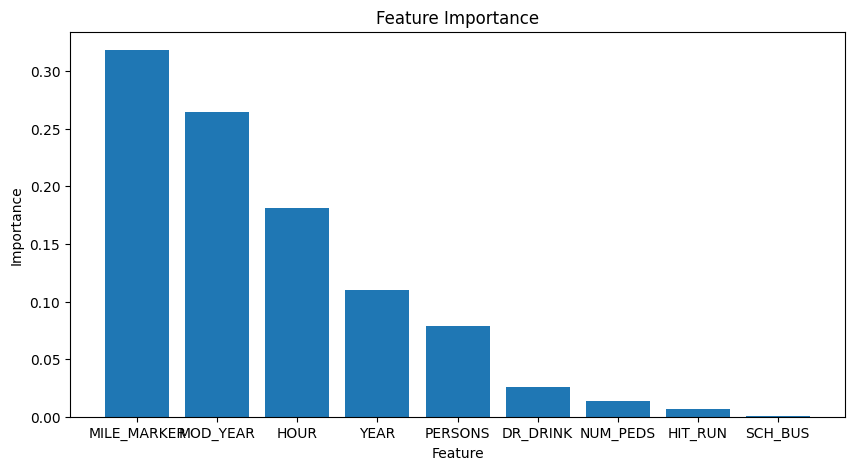

In [80]:
impts = rf_mod_3.feature_importances_

idxs = np.argsort(impts)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(len(impts)), impts[idxs], align="center")
plt.xticks(range(len(impts)), [feature_names[i] for i in idxs]) 
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


#### Model 4 - Accidents from 2001 to 2007:

In [81]:
type(X_resampled_4)

pandas.core.frame.DataFrame

In [82]:
type(y_resampled_4)

pandas.core.series.Series

In [83]:
# Make sure all variables are quantitative:
X_resampled_4.dtypes

YEAR             int64
NUM_PEDS         int64
PERSONS          int64
HOUR             int64
MILE_MARKER    float64
SCH_BUS          int64
MOD_YEAR       float64
DR_DRINK         int64
HIT_RUN          int64
dtype: object

In [85]:
rf_mod_4 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_mod_4.fit(X_resampled_4, y_resampled_4)

# Test Predictions
preds_mod_4 = rf_mod_4.predict(X_test_4)

# Accuracy
acc_mod_4 = accuracy_score(y_test_4, preds_mod_4)
print("Test Accuracy:", acc_mod_4)


Test Accuracy: 0.4713925872616049


In [86]:
# Feature Importance Plot:
impts = rf_mod_4.feature_importances_

feature_names = X_resampled_4.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


MILE_MARKER: 0.29921698859057066
MOD_YEAR: 0.27221954001745763
HOUR: 0.19915135353678515
YEAR: 0.09337472710295532
PERSONS: 0.08812876074661292
DR_DRINK: 0.02071155455849594
NUM_PEDS: 0.017578308494446162
HIT_RUN: 0.008953068260413354
SCH_BUS: 0.000665698692262961


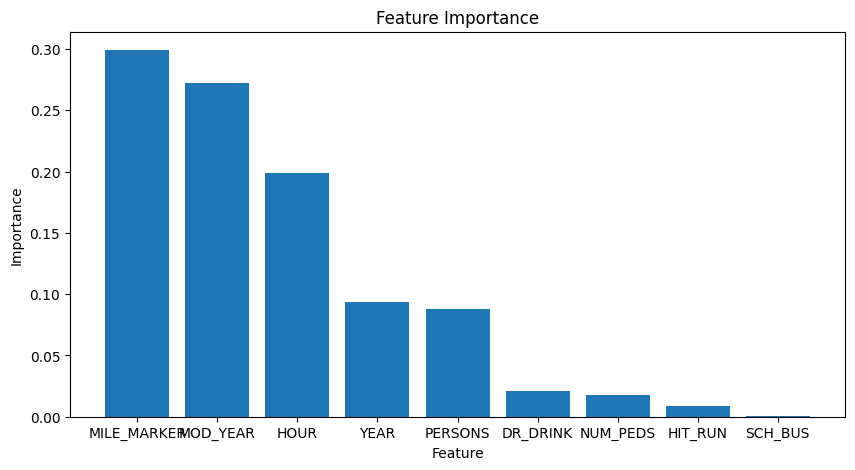

In [87]:
impts = rf_mod_4.feature_importances_

idxs = np.argsort(impts)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(len(impts)), impts[idxs], align="center")
plt.xticks(range(len(impts)), [feature_names[i] for i in idxs]) 
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


#### Model 5 - Accidents from 2008 to 2014:

In [88]:
type(X_resampled_5)

pandas.core.frame.DataFrame

In [89]:
type(y_resampled_5)

pandas.core.series.Series

In [90]:
# Make sure all variables are quantitative:
X_resampled_5.dtypes

YEAR             int64
NUM_PEDS         int64
NUM_VEHC         int64
PERSONS          int64
HOUR             int64
MILE_MARKER    float64
SCH_BUS          int64
MOD_YEAR       float64
DR_DRINK         int64
HIT_RUN          int64
dtype: object

In [92]:
rf_mod_5 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_mod_5.fit(X_resampled_5, y_resampled_5)

# Test Predictions
preds_mod_5 = rf_mod_5.predict(X_test_5)

# Accuracy
acc_mod_5 = accuracy_score(y_test_5, preds_mod_5)
print("Test Accuracy:", acc_mod_5)


Test Accuracy: 0.48050770625566636


In [93]:
# Feature Importance Plot:
impts = rf_mod_5.feature_importances_

feature_names = X_resampled_5.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


MOD_YEAR: 0.3472337158286761
HOUR: 0.23860031386181563
MILE_MARKER: 0.12661809249076925
YEAR: 0.12013334021656621
PERSONS: 0.07170832820406374
DR_DRINK: 0.03680285418590895
NUM_VEHC: 0.030720408398448577
NUM_PEDS: 0.019220546510370584
HIT_RUN: 0.00804463806987877
SCH_BUS: 0.000917762233502309


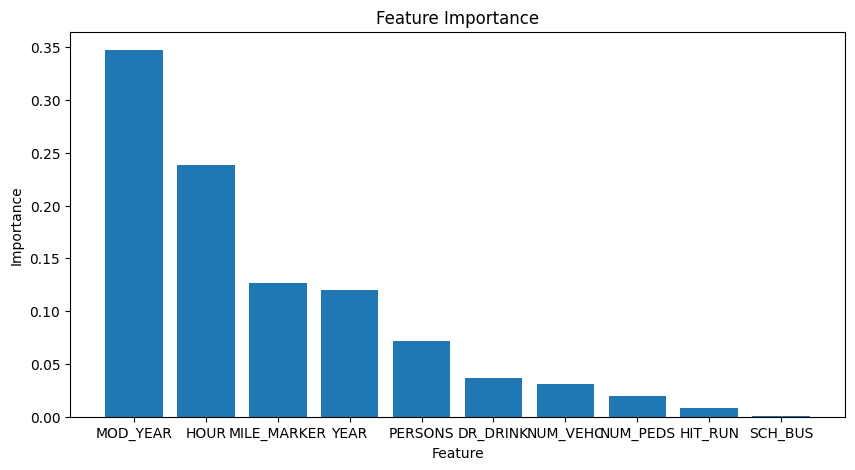

In [94]:
impts = rf_mod_5.feature_importances_

idxs = np.argsort(impts)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(len(impts)), impts[idxs], align="center")
plt.xticks(range(len(impts)), [feature_names[i] for i in idxs]) 
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


#### Model 6 - Accidents from 2015 to 2022:

In [95]:
type(X_resampled_6)

pandas.core.frame.DataFrame

In [96]:
type(y_resampled_6)

pandas.core.series.Series

In [97]:
# Make sure all variables are quantitative:
X_resampled_6.dtypes

YEAR                               int64
NUM_PEDS                           int64
NUM_VEHC                           int64
PERSONS                            int64
DAYNAME                            int64
                                   ...  
WEATHERNAME_Rain                    bool
WEATHERNAME_Reported as Unknown     bool
WEATHERNAME_Severe Crosswinds       bool
WEATHERNAME_Snow                    bool
WEATHERNAME_Unknown                 bool
Length: 116, dtype: object

In [99]:
rf_mod_6 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_mod_6.fit(X_resampled_6, y_resampled_6)

# Test Predictions
preds_mod_6 = rf_mod_6.predict(X_test_6)

# Accuracy
acc_mod_6 = accuracy_score(y_test_6, preds_mod_6)
print("Test Accuracy:", acc_mod_6)


Test Accuracy: 0.4546732255797611


In [100]:
# Feature Importance Plot:
impts = rf_mod_6.feature_importances_

feature_names = X_resampled_6.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


MOD_YEAR: 0.09710770556538437
MILE_MARKER: 0.0582016946765235
DAYNAME: 0.04807827271520061
HOUR: 0.039483868704019376
YEAR: 0.03215398836876704
DR_DRINK: 0.024996062009919048
PERSONS: 0.021721213966203478
DAY_WEEKNAME_Tuesday: 0.02062439169201083
DAY_WEEKNAME_Thursday: 0.020394581425780715
RUR_URBNAME_Urban: 0.01759748010315467
FUNC_SYSNAME_Minor Arterial: 0.01740270397172199
ROUTENAME_State Highway: 0.01734325651334838
RUR_URBNAME_Rural: 0.01704086099992985
LGT_CONDNAME_Daylight: 0.016977780893547675
LGT_CONDNAME_Dark - Not Lighted: 0.016446272561824207
WEATHERNAME_Cloudy: 0.015817224169302344
NUM_VEHC: 0.015436813398133969
FUNC_SYSNAME_Principal Arterial - Other: 0.015299102065209728
REL_ROADNAME_On Roadway: 0.015152423960896874
REL_ROADNAME_On Roadside: 0.014717918936121876
DAY_WEEKNAME_Wednesday: 0.014463546105930345
TYP_INTNAME_Not an Intersection: 0.014127143006691496
LGT_CONDNAME_Dark - Lighted: 0.014094225447998798
COLLISION_TYPE_Angle: 0.013884984227833307
MONTHNAME_December: 

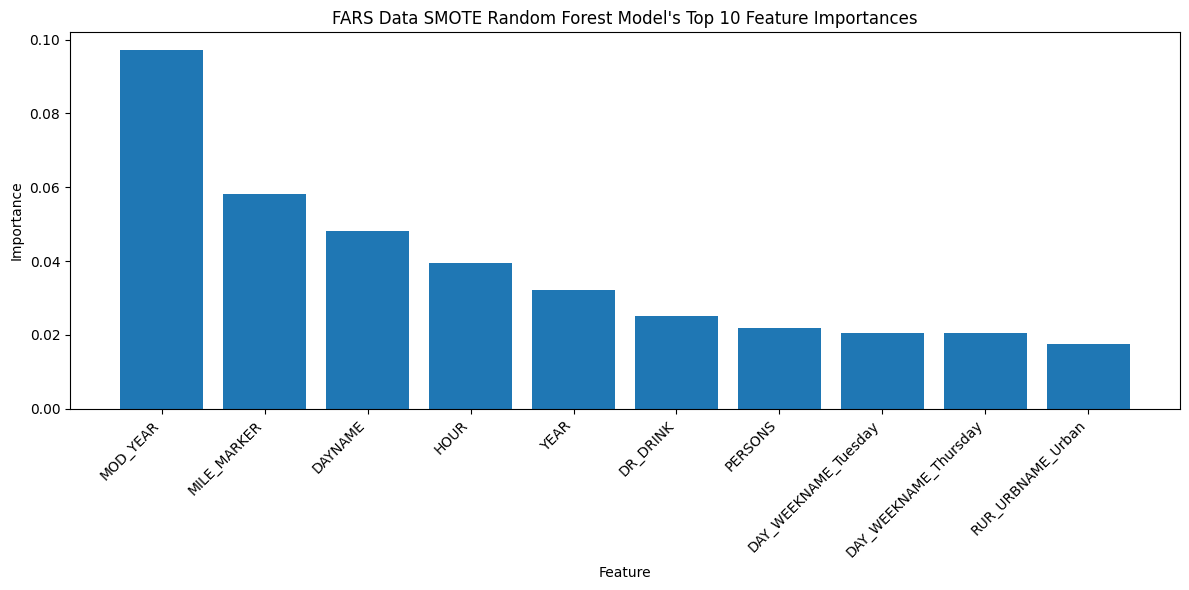

In [101]:
impts = rf_mod_6.feature_importances_

idxs = np.argsort(impts)[::-1]

# Top 10 indices
top_idxs = idxs[:10]

# Plotting only top 25
plt.figure(figsize=(12, 6))
plt.title("FARS Data SMOTE Random Forest Model's Top 10 Feature Importances")
plt.bar(range(len(top_idxs)), impts[top_idxs], align="center")
plt.xticks(range(len(top_idxs)), [feature_names[i] for i in top_idxs], rotation=45, ha='right') 
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout() 
plt.show()


#### Feed Forward Neural Networks:

In [113]:
type(X_resampled_1)

pandas.core.frame.DataFrame

In [114]:
type(y_resampled_1)

pandas.core.series.Series

In [115]:
X_resampled_1.shape

(22808, 7)

In [116]:
y_resampled_1.shape

(22808,)

Decided to convert "3+" to 3 for the sake of making it a quantitative variable. So whenever the model predicts a value of 3, it means that there could be 3 or more deaths.

In [117]:
# Change string to integer labels
y_resampled_1_int = y_resampled_1.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

print(np.unique(y_resampled_1_int))


[0 1 2 3]


#### Justification of Each Neural Network Component:

I used a ReLU activation because deaths cannot be < 0, so a ReLU function is the most suitable activation function. The softmax function is appropriate because the response variable has 4 categories to choose among. 

I chose the Adam optimizer because it can adapt the model parameters' learning rates based on past gradients. Additonally, this optimizer makes use of a measure called the momentum, which helps the optimizer speed up the process of learning based on previous gradients' effect on the direction to update values.

The loss function of sparse categorical cross-entropy is appropriate for multi-class classification with 3 or more categories & when the target variable is an integer. 


#### First trying a model without the SMOTE resampling but another type of resampling:

In [119]:
print(np.unique(y_train_1))

['0' '1' '2' '3+']


In [120]:
# Change string to integer labels
y_train_1_int = y_train_1.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

print(np.unique(y_train_1_int))

[0 1 2 3]


In [121]:
model_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(7,)), # input shape of 7 since this time period's df has 7 features
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 neurons for 4 categories
])

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

history_1 = model_1.fit(X_resampled_1, y_resampled_1_int, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100


2024-04-08 19:31:00.686231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


286/286 [==============================] - 1s 2ms/step - loss: 9.5127 - accuracy: 0.2984 - val_loss: 4.0270 - val_accuracy: 0.0000e+00
Epoch 2/100
286/286 [==============================] - 0s 1ms/step - loss: 2.5375 - accuracy: 0.3045 - val_loss: 5.4007 - val_accuracy: 0.0000e+00
Epoch 3/100
286/286 [==============================] - 0s 1ms/step - loss: 2.9002 - accuracy: 0.3062 - val_loss: 0.7435 - val_accuracy: 0.8801
Epoch 4/100
286/286 [==============================] - 0s 1ms/step - loss: 2.4292 - accuracy: 0.3128 - val_loss: 3.8454 - val_accuracy: 0.0000e+00
Epoch 5/100
286/286 [==============================] - 0s 2ms/step - loss: 2.7049 - accuracy: 0.3127 - val_loss: 11.1041 - val_accuracy: 0.0000e+00
Epoch 6/100
286/286 [==============================] - 0s 1ms/step - loss: 2.3640 - accuracy: 0.3098 - val_loss: 2.3416 - val_accuracy: 0.0000e+00
Epoch 7/100
286/286 [==============================] - 0s 2ms/step - loss: 2.2899 - accuracy: 0.3168 - val_loss: 9.1664 - val_accurac

In [122]:
# Change string to integer labels for the test data
y_test_1_int = y_test_1.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

# Evaluate the model 
loss_1, accuracy_1 = model_1.evaluate(X_test_1, y_test_1_int)
print("Accuracy on test set: {:.2f}%".format(accuracy_1 * 100))


124/124 [==============================] - 0s 773us/step - loss: 1.7112 - accuracy: 0.0596
Accuracy on test set: 5.96%


In [123]:
X_resampled_2.shape

(28424, 8)

In [124]:
y_resampled_2.shape

(28424,)

In [125]:
y_resampled_2_int = y_resampled_2.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

print(np.unique(y_resampled_2_int))


[0 1 2 3]


In [126]:
model_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(8,)),  # input shape of 8 since this time period's df has 8 features
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 neurons for 4 categories
])

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history_2 = model_2.fit(X_resampled_2, y_resampled_2_int, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
356/356 [==============================] - 1s 1ms/step - loss: 188.6911 - accuracy: 0.3000 - val_loss: 243.6297 - val_accuracy: 0.0000e+00
Epoch 2/100
356/356 [==============================] - 0s 1ms/step - loss: 75.3456 - accuracy: 0.2986 - val_loss: 403.8156 - val_accuracy: 0.3782
Epoch 3/100
356/356 [==============================] - 0s 1ms/step - loss: 83.7121 - accuracy: 0.3040 - val_loss: 34.8026 - val_accuracy: 0.0273
Epoch 4/100
356/356 [==============================] - 0s 1ms/step - loss: 70.5549 - accuracy: 0.3032 - val_loss: 371.0188 - val_accuracy: 0.0000e+00
Epoch 5/100
356/356 [==============================] - 0s 1ms/step - loss: 78.6835 - accuracy: 0.3057 - val_loss: 141.8788 - val_accuracy: 0.0665
Epoch 6/100
356/356 [==============================] - 0s 1ms/step - loss: 76.6520 - accuracy: 0.3051 - val_loss: 75.1454 - val_accuracy: 0.0000e+00
Epoch 7/100
356/356 [==============================] - 0s 1ms/step - loss: 76.9748 - accuracy: 0.3050 - val_loss:

In [127]:
y_test_2_int = y_test_2.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

loss_2, accuracy_2 = model_2.evaluate(X_test_2, y_test_2_int)
print("Accuracy on test set: {:.2f}%".format(accuracy_2 * 100))


139/139 [==============================] - 0s 747us/step - loss: 1.1780 - accuracy: 0.5306
Accuracy on test set: 53.06%


In [128]:
X_resampled_3.shape

(26580, 9)

In [129]:
y_resampled_3.shape

(26580,)

In [130]:
y_resampled_3_int = y_resampled_3.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

print(np.unique(y_resampled_3_int))


[0 1 2 3]


In [131]:
model_3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(9,)),  # input shape of 9 since this time period's df has 9 features
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 neurons for 4 categories
])

model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # use sparse categorical crossentropy
              metrics=['accuracy'])

history_3 = model_3.fit(X_resampled_3, y_resampled_3_int, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
333/333 [==============================] - 1s 2ms/step - loss: 15.5250 - accuracy: 0.3100 - val_loss: 16.4240 - val_accuracy: 0.0000e+00
Epoch 2/100
333/333 [==============================] - 0s 1ms/step - loss: 3.8535 - accuracy: 0.3097 - val_loss: 15.2963 - val_accuracy: 0.0000e+00
Epoch 3/100
333/333 [==============================] - 0s 1ms/step - loss: 3.1118 - accuracy: 0.3279 - val_loss: 1.7185 - val_accuracy: 0.3427
Epoch 4/100
333/333 [==============================] - 0s 1ms/step - loss: 3.4152 - accuracy: 0.3277 - val_loss: 18.5440 - val_accuracy: 0.0000e+00
Epoch 5/100
333/333 [==============================] - 0s 1ms/step - loss: 3.2974 - accuracy: 0.3274 - val_loss: 20.5107 - val_accuracy: 0.0000e+00
Epoch 6/100
333/333 [==============================] - 0s 1ms/step - loss: 3.0373 - accuracy: 0.3434 - val_loss: 3.2003 - val_accuracy: 0.0169
Epoch 7/100
333/333 [==============================] - 0s 1ms/step - loss: 3.0578 - accuracy: 0.3430 - val_loss: 13.0316 

In [132]:
y_test_3_int = y_test_3.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

loss_3, accuracy_3 = model_3.evaluate(X_test_3, y_test_3_int)
print("Accuracy on test set: {:.2f}%".format(accuracy_3 * 100))


124/124 [==============================] - 0s 734us/step - loss: 1.1506 - accuracy: 0.5478
Accuracy on test set: 54.78%


In [133]:
X_resampled_4.shape

(19180, 9)

In [134]:
y_resampled_4.shape

(19180,)

In [135]:
y_resampled_4_int = y_resampled_4.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

print(np.unique(y_resampled_4_int))


[0 1 2 3]


In [136]:
model_4 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(9,)),  # input shape of 9 since this time period's df has 9 features
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 neurons for 4 categories
])

model_4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history_4 = model_4.fit(X_resampled_4, y_resampled_4_int, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
240/240 [==============================] - 1s 2ms/step - loss: 16.0812 - accuracy: 0.3124 - val_loss: 11.2531 - val_accuracy: 0.0000e+00
Epoch 2/100
240/240 [==============================] - 0s 1ms/step - loss: 3.1264 - accuracy: 0.3100 - val_loss: 2.7593 - val_accuracy: 0.0120
Epoch 3/100
240/240 [==============================] - 0s 1ms/step - loss: 3.0244 - accuracy: 0.3197 - val_loss: 2.8833 - val_accuracy: 0.0000e+00
Epoch 4/100
240/240 [==============================] - 0s 1ms/step - loss: 2.6491 - accuracy: 0.3111 - val_loss: 4.5936 - val_accuracy: 0.0000e+00
Epoch 5/100
240/240 [==============================] - 0s 1ms/step - loss: 2.4378 - accuracy: 0.3259 - val_loss: 7.6503 - val_accuracy: 0.0000e+00
Epoch 6/100
240/240 [==============================] - 0s 1ms/step - loss: 3.5561 - accuracy: 0.3127 - val_loss: 5.7819 - val_accuracy: 0.0000e+00
Epoch 7/100
240/240 [==============================] - 0s 1ms/step - loss: 2.6267 - accuracy: 0.3330 - val_loss: 1.0537 

Epoch 57/100
240/240 [==============================] - 0s 1ms/step - loss: 1.5527 - accuracy: 0.3610 - val_loss: 1.4637 - val_accuracy: 0.1702
Epoch 58/100
240/240 [==============================] - 0s 1ms/step - loss: 1.5081 - accuracy: 0.3584 - val_loss: 1.9034 - val_accuracy: 0.0104
Epoch 59/100
240/240 [==============================] - 0s 1ms/step - loss: 1.5703 - accuracy: 0.3560 - val_loss: 2.7140 - val_accuracy: 0.0000e+00
Epoch 60/100
240/240 [==============================] - 0s 1ms/step - loss: 1.8780 - accuracy: 0.3474 - val_loss: 2.4938 - val_accuracy: 0.0000e+00
Epoch 61/100
240/240 [==============================] - 0s 1ms/step - loss: 1.5048 - accuracy: 0.3569 - val_loss: 4.1170 - val_accuracy: 0.0000e+00
Epoch 62/100
240/240 [==============================] - 0s 1ms/step - loss: 1.5684 - accuracy: 0.3545 - val_loss: 3.8459 - val_accuracy: 0.0000e+00
Epoch 63/100
240/240 [==============================] - 0s 1ms/step - loss: 1.7030 - accuracy: 0.3507 - val_loss: 2.4474

In [137]:
y_test_4_int = y_test_4.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

loss_4, accuracy_4 = model_4.evaluate(X_test_4, y_test_4_int)
print("Accuracy on test set: {:.2f}%".format(accuracy_4 * 100))


87/87 [==============================] - 0s 770us/step - loss: 1.0796 - accuracy: 0.5847
Accuracy on test set: 58.47%


In [138]:
X_resampled_5.shape

(15248, 10)

In [139]:
y_resampled_5.shape

(15248,)

In [140]:
y_resampled_5_int = y_resampled_5.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

print(np.unique(y_resampled_5_int))


[0 1 2 3]


In [141]:
model_5 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10,)),  # input shape of 10 since this time period's df has 10 features
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 neurons for 4 categories
])

model_5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # use sparse categorical crossentropy
              metrics=['accuracy'])

history_5 = model_5.fit(X_resampled_5, y_resampled_5_int, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
191/191 [==============================] - 1s 2ms/step - loss: 28.5764 - accuracy: 0.2987 - val_loss: 14.5406 - val_accuracy: 0.0000e+00
Epoch 2/100
191/191 [==============================] - 0s 1ms/step - loss: 2.3233 - accuracy: 0.3078 - val_loss: 3.7708 - val_accuracy: 0.2990
Epoch 3/100
191/191 [==============================] - 0s 1ms/step - loss: 2.5293 - accuracy: 0.3064 - val_loss: 2.4024 - val_accuracy: 0.0052
Epoch 4/100
191/191 [==============================] - 0s 1ms/step - loss: 2.4776 - accuracy: 0.3205 - val_loss: 5.5829 - val_accuracy: 0.0000e+00
Epoch 5/100
191/191 [==============================] - 0s 1ms/step - loss: 2.8218 - accuracy: 0.3190 - val_loss: 7.9395 - val_accuracy: 0.0000e+00
Epoch 6/100
191/191 [==============================] - 0s 1ms/step - loss: 1.9746 - accuracy: 0.3357 - val_loss: 2.0674 - val_accuracy: 0.1098
Epoch 7/100
191/191 [==============================] - 0s 1ms/step - loss: 2.6049 - accuracy: 0.3337 - val_loss: 5.5282 - val_ac

Epoch 57/100
191/191 [==============================] - 0s 1ms/step - loss: 1.4976 - accuracy: 0.3906 - val_loss: 6.4588 - val_accuracy: 0.0000e+00
Epoch 58/100
191/191 [==============================] - 0s 1ms/step - loss: 1.4979 - accuracy: 0.3969 - val_loss: 3.8725 - val_accuracy: 0.0000e+00
Epoch 59/100
191/191 [==============================] - 0s 1ms/step - loss: 1.4587 - accuracy: 0.3945 - val_loss: 7.2990 - val_accuracy: 0.0000e+00
Epoch 60/100
191/191 [==============================] - 0s 1ms/step - loss: 1.5093 - accuracy: 0.3942 - val_loss: 5.4635 - val_accuracy: 0.0000e+00
Epoch 61/100
191/191 [==============================] - 0s 1ms/step - loss: 1.6051 - accuracy: 0.3883 - val_loss: 2.7332 - val_accuracy: 0.0000e+00
Epoch 62/100
191/191 [==============================] - 0s 1ms/step - loss: 1.4952 - accuracy: 0.3893 - val_loss: 2.9660 - val_accuracy: 0.0000e+00
Epoch 63/100
191/191 [==============================] - 0s 2ms/step - loss: 1.4362 - accuracy: 0.3979 - val_loss

In [142]:
y_test_5_int = y_test_5.replace({'0': 0, '1': 1, '2': 2, '3+': 3})

loss_5, accuracy_5 = model_5.evaluate(X_test_5, y_test_5_int)
print("Accuracy on test set: {:.2f}%".format(accuracy_5 * 100))


69/69 [==============================] - 0s 828us/step - loss: 1.5721 - accuracy: 0.3332
Accuracy on test set: 33.32%
